# Segmentez des clients d'un site e-commerce
Nous sommes consultants pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne. Olist souhaite que nous fournissions à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. </br>
L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles, fournir à l’équipe marketing une description actionable de notre segmentation et de sa logique sous-jacente pour une utilisation optimale, et proposer un contrat de maintenance basé sur une analyse de la stabilité des segments au cours du temps. </br>
Dans ce notebook, nous allons tester et comparer différents modèles de clustering.

# Sommaire :
- **Partie 1:** <a href="#C1">Importation des données</a>
- **Partie 2:** <a href="#C2">Méthodes traditionnelles</a>
    - <a href="#C3">RFM</a>
    - <a href="#C4">Loi de Pareto</a>
- **Partie 3:** <a href="#C5">Méthodes de clustering</a>
    - <a href="#C6">K-Means</a>
    - <a href="#C7">DBSCAN</a>
    - <a href="#C8">Agglomerative Clustering</a>
- **Partie 4:** <a href="#C9">Sélection du modèle</a>
- **Partie 5:** <a href="#C10">Exportation du jeu de données</a>

# <a name="C1">Partie 1: Importation des jeux de données</a>
Importons tout d'abord les librairies utiles pour l'utilisation des modèles de clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import yellowbrick
import timeit

from math import floor
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.datasets import load_credit
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import DistanceMetric

pd.set_option('display.max_columns', 100)

On peut à présent charger les jeux de données.

In [2]:
data = pd.read_csv('dataNettoye.csv', sep=',',encoding='utf-8')
dataPCA = pd.read_csv('dataNettoyePCA.csv', sep=',',encoding='utf-8')
data.head()

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng
0,1,2.0,1.0,146.87,4.0,8.0,2017-05-16 15:05:35,office_furniture,-20.509898,-47.397866
1,1,8.0,3.0,335.48,5.0,16.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746
2,1,7.0,1.0,157.73,5.0,26.0,2018-05-19 16:07:45,office_furniture,-23.527788,-46.660310
3,1,1.0,1.0,173.30,5.0,14.0,2018-03-13 16:06:38,office_furniture,-23.496930,-46.185352
4,1,8.0,1.0,252.25,5.0,11.0,2018-07-29 09:51:30,home_confort,-22.987222,-47.151073


# <a name="C2">Partie 2: Méthodes traditionnelles</a>
Avant de tester des modèles plus complexes de clustering via machine learning, on peut s'intéresser aux premières méthodes simples de segmentation.
## <a name="C3">2.1: RFM</a>
La segmentation RFM consiste à segmenter les clients en fonction de leur comportement d’achat. C’est une segmentation 100% comportementale. On ne segmente pas  les clients en fonction de ce qu’ils achètent. Le principe sous-jacent est simple : un client qui a acheté récemment, qui achète fréquemment et qui génère beaucoup de chiffre d’affaires commandera à nouveau, à coup quasiment sûr. Les chances de se tromper sont très faibles. La segmentation RFM repose sur ces 3 critères : Récence / Fréquence / Montant.

Pour calculer les scores RFM, on va attribuer une note de 1 à 5 correspondant au quantile dans lequel se trouve la valeur de la variable utilisée. On utilisera `last_order_purchase_timestamp` pour la récence, `nb_orders` pour la fréquence et `mean_payment_value` pour le montant.

In [3]:
def scoreRFM(col):
    """Fonction qui prend en entrée une colonne et retourne son score RFM"""
    
    df = pd.DataFrame(col)
    #On récupère les 5 quantiles de la colonne
    q20 = col.quantile(q=0.2)
    q40 = col.quantile(q=0.4)
    q60 = col.quantile(q=0.6)
    q80 = col.quantile(q=0.8)
    
    #On affecte le score en fonction de la tranche dans laquelle se situe la valeur
    df.loc[(col<q20), 'RFM'] = 1
    df.loc[(col>=q20) & (col<q40), 'RFM'] = 2
    df.loc[(col>=q40) & (col<q60), 'RFM'] = 3
    df.loc[(col>=q60) & (col<q80), 'RFM'] = 4
    df.loc[(col>=q80), 'RFM'] = 5
    return(df.RFM)

def scoreRFM_asymetrique(col):
    """Fonction qui prend en entrée une colonne dont la distribution est beaucoup trop asymétrique et retourne son score 
    RFM"""
    
    #On fabrique nos 5 quantiles à partir du maximum de la colonne
    df = pd.DataFrame(col)
    q20 = (col.max())/5
    q40 = (col.max())*2/5
    q60 = (col.max())*3/5
    q80 = (col.max())*4/5

    #On affecte le score en fonction de la tranche dans laquelle se situe la valeur
    df.loc[(col<q20), 'RFM'] = 1
    df.loc[(col>=q20) & (col<q40), 'RFM'] = 2
    df.loc[(col>=q40) & (col<q60), 'RFM'] = 3
    df.loc[(col>=q60) & (col<q80), 'RFM'] = 4
    df.loc[(col>=q80), 'RFM'] = 5
    return(df.RFM)


def calcul_RFM(df):
    """Fonction qui prend en entrée un DataFrame et calcule son score RFM"""
    
    df['RFM_R'] = scoreRFM(pd.to_datetime(df['last_order_purchase_timestamp']))
    df['RFM_F'] = scoreRFM_asymetrique(df['nb_orders'])
    df['RFM_M'] = scoreRFM(df['mean_payment_value'])
    df['RFM'] = 100*df['RFM_R'] + 10*df['RFM_F'] + df['RFM_M']
    return df[['RFM_R', 'RFM_F', 'RFM_M', 'RFM']]

In [4]:
dataRFM = calcul_RFM(data)
dataRFM.head()

,RFM_R,RFM_F,RFM_M,RFM
0,1.0,1.0,4.0,114.0
1,3.0,1.0,5.0,315.0
2,4.0,1.0,4.0,414.0
3,4.0,1.0,4.0,414.0
4,5.0,1.0,5.0,515.0


A partir de ces scores, on peut créer des groupes de clients.

In [5]:
#clients Stars
clients_stars = dataRFM[((dataRFM['RFM_R']>2) & (dataRFM['RFM_F']>2) & (dataRFM['RFM_M']>2))].index
dataRFM.loc[clients_stars,'categorie_client'] = 'Star'

C:\Users\vbour\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\vbour\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [6]:
#Anciennes Stars
anciennes_stars = dataRFM[((dataRFM['RFM_R']<2) & (dataRFM['RFM_F']>2) & (dataRFM['RFM_M']>2))].index
dataRFM.loc[anciennes_stars,'categorie_client'] = 'Ancienne Star'

In [7]:
#Insatisfaits
insatisfaits = dataRFM[((dataRFM['RFM_R']<2) & (dataRFM['RFM_F']<2) & (dataRFM['RFM_M']<2))].index
dataRFM.loc[insatisfaits,'categorie_client'] = 'Insatisfait'

In [8]:
#Insatisfaits à relancer
insatisfaits_relancer = dataRFM[((dataRFM['RFM_R']<2) & (dataRFM['RFM_F']<2) & (dataRFM['RFM_M']>2))].index
dataRFM.loc[insatisfaits_relancer,'categorie_client'] = 'Insatisfait à relancer'

In [9]:
#Nouveaux clients
nouveaux = dataRFM[((dataRFM['RFM_R']==5) & (dataRFM['RFM_F']==1) & (dataRFM['RFM_M']<4))].index
dataRFM.loc[nouveaux,'categorie_client'] = 'Nouveau'

In [10]:
#Dépensiers
depensiers = dataRFM[((dataRFM['RFM_R']<3) & (dataRFM['RFM_F']<3) & (dataRFM['RFM_M']>3))].index
dataRFM.loc[depensiers,'categorie_client'] = 'Dépensier'

In [11]:
#Fidèles
fideles = dataRFM[((dataRFM['RFM_R']<3) & (dataRFM['RFM_F']>2) & (dataRFM['RFM_M']<3))].index
dataRFM.loc[fideles,'categorie_client'] = 'Fidèle'

Visualisons à présent les proportions des différents groupes de clients.

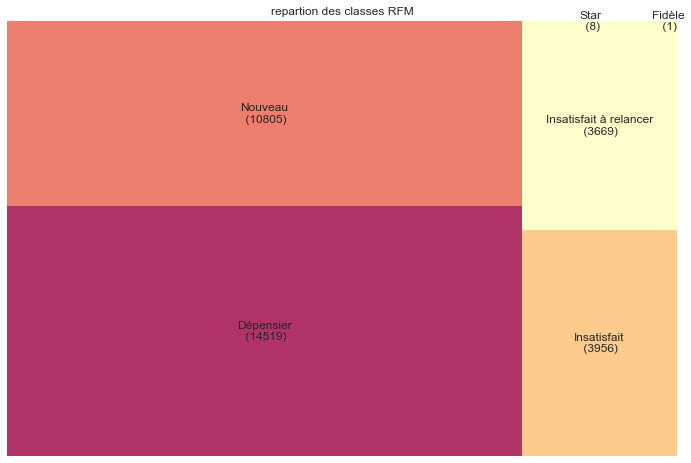

In [12]:
note_pie = dataRFM['categorie_client'].value_counts()
labels = note_pie.index
labels = []
for i in range(0,len(note_pie)):
    labels.append(f"{note_pie.index[i]}\n ({note_pie[i]})")
    
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=note_pie, label=labels, alpha=.8, color=colors)
plt.axis('off')
plt.title('repartion des classes RFM')
plt.show()

Le choix des catégories n'est ici pas pertinent et inutilisable car on obtient des catégories qui contiennent 0% ou presque des clients.
## <a name="C4">2.2: Loi de Pareto</a>
L'économiste Italien Vilfredo Pareto a constaté dans les années 1900 que dans son pays, 20% des individus détenaient 80% des richesses. C'est une loi empririque qui a par la suite été observée dans de nombreux domaines, notamment le commerce. Voyons si c'est le cas dans notre jeu de données.

In [13]:
df = data.copy()
df['total_payment'] = (df['mean_payment_value'] * df['nb_orders'])
df.head()

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng,RFM_R,RFM_F,RFM_M,RFM,total_payment
0,1,2.0,1.0,146.87,4.0,8.0,2017-05-16 15:05:35,office_furniture,-20.509898,-47.397866,1.0,1.0,4.0,114.0,146.87
1,1,8.0,3.0,335.48,5.0,16.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746,3.0,1.0,5.0,315.0,335.48
2,1,7.0,1.0,157.73,5.0,26.0,2018-05-19 16:07:45,office_furniture,-23.527788,-46.660310,4.0,1.0,4.0,414.0,157.73
3,1,1.0,1.0,173.30,5.0,14.0,2018-03-13 16:06:38,office_furniture,-23.496930,-46.185352,4.0,1.0,4.0,414.0,173.30
4,1,8.0,1.0,252.25,5.0,11.0,2018-07-29 09:51:30,home_confort,-22.987222,-47.151073,5.0,1.0,5.0,515.0,252.25


In [14]:
df.sort_values(by = 'total_payment', ascending=False, inplace=True)
df.head()

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng,RFM_R,RFM_F,RFM_M,RFM,total_payment
26242,2,10.0,1.5,3785.815,5.000000,15.0,2017-04-01 15:58:41,small_appliances,-22.871875,-42.269220,1.0,1.0,5.0,115.0,7571.63
12989,1,8.0,2.0,6929.310,5.000000,18.0,2017-02-12 20:37:36,housewares,-20.500241,-54.568666,1.0,1.0,5.0,115.0,6929.31
20384,1,1.0,4.0,6922.210,4.013674,20.0,2018-07-25 18:10:17,computers,-20.274743,-40.284131,5.0,1.0,5.0,515.0,6922.21
3771,1,1.0,2.0,6726.660,5.000000,11.0,2017-05-24 18:14:34,art,-22.205949,-49.954940,1.0,1.0,5.0,115.0,6726.66
11645,1,8.0,2.0,4764.340,4.000000,18.0,2017-04-18 18:50:13,small_appliances,-23.680005,-46.417609,1.0,1.0,5.0,115.0,4764.34


In [15]:
# on récupère les 20% meilleurs clients
lim = floor(df.shape[0]*0.2)
df_stars = df.iloc[0:lim, :]

In [16]:
#On regarde si ce petit groupe génère 80% des revenus
CA_stars = df_stars['total_payment'].sum()
CA = df['total_payment'].sum()
p = round(CA_stars*100/CA)
print("Les meilleurs 20% de clients représentent " + str(p) + "% du chiffre d'affaires total")

Les meilleurs 20% de clients représentent 53% du chiffre d'affaires total


La loi de Pareto ne se vérifie pas ici.

Les méthodes traditionnelles simples ne donnent pas de résultats probants. Orientons-nous vers des méthodes de clustering un peu plus complexes.

# <a name="C5">Partie 3: Méthodes de clustering</a>
Les algorithmes de clustering permettent de partitionner les données en sous-groupes, ou clusters, de manière non supervisée. Intuitivement, ces sous-groupes regroupent entre elles des observations similaires. </br>
Dans le e-commerce, de manière générale, on retrouve 3 grandes catégories de clients:
- les clients stars, que l'on peut diviser en deux sous-groupes:
    - les stars
    - les stars qui n'ont pas consommer depuis un moment
- les insatisfaits, que l'on peut également diviser en deux sous-groupes:
    - les râleurs qui ne sont jamais contents
    - les insatisfaits dû à un problème lors de leur commande (retard, mauvais produit...)
- les autres clients à distinguer en d'autres sous-groupes en fonction du contexte 

In [17]:
#On prépare un tableau pour pouvoir comparer les modèles
listeModeles = []

listeSilhouetteScore, listeTempsCalcul, listeDaviesBouldin = [], [], []

## <a name="C6">3.1: K-Means</a>
Le principe de l'alpgorithme du K-Means est de choisir à l'avance un nombre k de clusters. On choisit aléatoirement k centroïdes puis on associe à chaque point le cluster auquel il appartient. On re-calcule les centroïdes et contrôle à nouveau l'appartenance des points aux clusters. On répète le processus un nombre prédéfini de fois jusqu'à obtenir des clusters stables.

In [18]:
#On va commencer par un nombre réduit de features
listeVar = ['nb_orders', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time']

df = data[listeVar]
df.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time
0,1,146.87,4.0,8.0
1,1,335.48,5.0,16.0
2,1,157.73,5.0,26.0
3,1,173.30,5.0,14.0
4,1,252.25,5.0,11.0


In [19]:
# normalisation avec StandardScaler
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df))

In [20]:
#Le jeu de données étant grand, on sélectionne aléatoirement 40% du jeu de données
sample = round(df.shape[0]*0.4)
df_sample = df_std.sample(sample, random_state=2).copy()
df_sample.shape

(37343, 4)

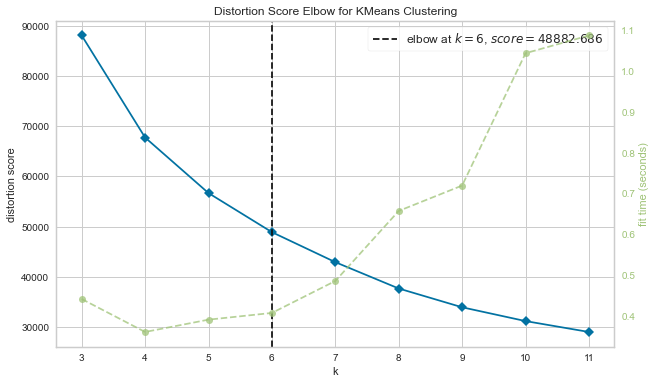

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
plt.figure(figsize=(10,6))
model = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
visualizer = KElbowVisualizer(model, k=(3, 12), timings=True)
visualizer.fit(df_sample)    
visualizer.show()

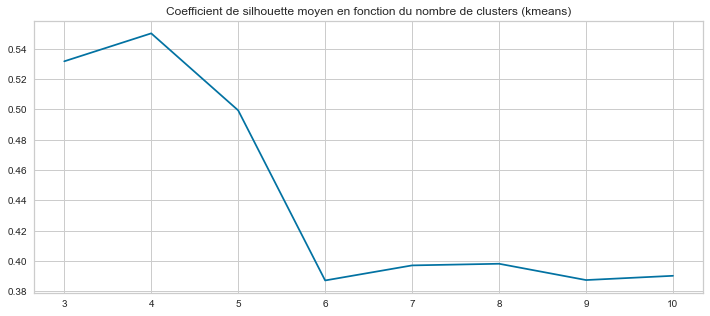

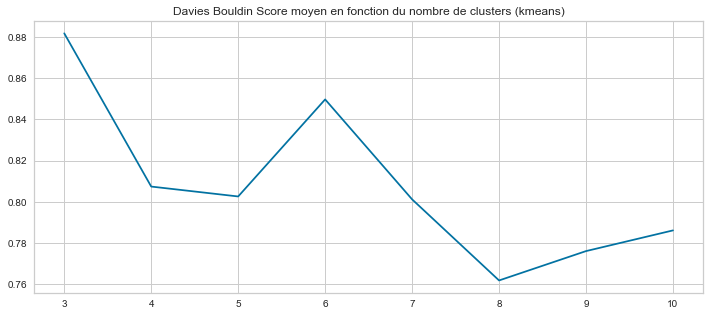

Silhouette Score est maximal pour 4 clusters (score = 0.5501772858211345)
Davies Bouldin Score est minimal pour 8 clusters (score = 0.7618933831749326)



In [22]:
dict_kmeans = {}

for k in range(3,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0).fit(df_sample)
    dict_kmeans[k] = kmeans

silhouettes_kmeans = {}
for i in range(3,11):
    silhouettes_kmeans[i] = silhouette_score(X=df_sample, labels=list(dict_kmeans[i].labels_))
    
plt.figure(figsize=(12,5))
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.lineplot(x=list(silhouettes_kmeans.keys()), y=list(silhouettes_kmeans.values()))
plt.show()

davies_bouldin_kmeans = {}
for i in range(3, 11):
    davies_bouldin_kmeans[i] = davies_bouldin_score(X=df_sample, labels=list(dict_kmeans[i].labels_))
    
plt.figure(figsize=(12,5))
plt.title('Davies Bouldin Score moyen en fonction du nombre de clusters (kmeans)')
sns.lineplot(x=list(davies_bouldin_kmeans.keys()), y=list(davies_bouldin_kmeans.values()))
plt.show()

for key, value in silhouettes_kmeans.items():
    if value == max(silhouettes_kmeans.values()):
        print('Silhouette Score est maximal pour {} clusters (score = {})'.format(key, value), end='\n')
        n_clusters_silhouettes_kmeans = key

for key, value in davies_bouldin_kmeans.items():
    if value == min(davies_bouldin_kmeans.values()):
        print('Davies Bouldin Score est minimal pour {} clusters (score = {})'.format(key, value), end='\n\n')
        n_clusters_davies_bouldin_kmeans = key

A la vue des précédents graphiques, les valeurs candidates pour le nombres de clusters sont 4, 6 et 8. On va donc tester ces différentes valeurs pour voir si elles permettent un clustering pertinent d'un point de vue métier, et déterminer le nombre de clusters qui répond le mieux au besoin métier.

### 3.1.1: K-Means avec 4 clusters

In [23]:
listeModeles.append('K-Means 4 clusters')

In [24]:
#Entraînement du modèle
start_time = timeit.default_timer()
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=0)
clusters = kmeans.fit_predict(df_std)
time = timeit.default_timer() - start_time

#Scores du modèle
listeSilhouetteScore.append(silhouette_score(X=df_std, labels=kmeans.labels_))
listeDaviesBouldin.append(davies_bouldin_score(X=df_std, labels=kmeans.labels_))
listeTempsCalcul.append(time)

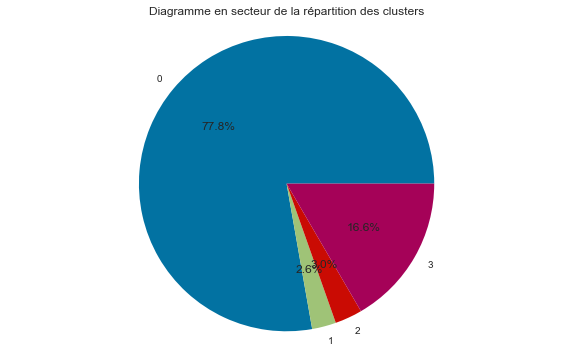

In [25]:
#Proportions des clusters
counts_kmeans = []
for i in np.unique(clusters):
    counts_kmeans.append(sum(clusters == i)/len(clusters))
labels_kmeans = np.unique(clusters)

plt.figure(figsize=(10, 6))
plt.pie(counts_kmeans, labels=labels_kmeans, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Diagramme en secteur de la répartition des clusters')
plt.show()

Les clusters semblent à première vue un peu disproportionnés. Regardons d'un peu plus près à quoi ils ressemblent.

In [26]:
#PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_std)

#TSNE
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_std)

C:\Users\vbour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\vbour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [27]:
#On récupère les centroïdes de nos clusters
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

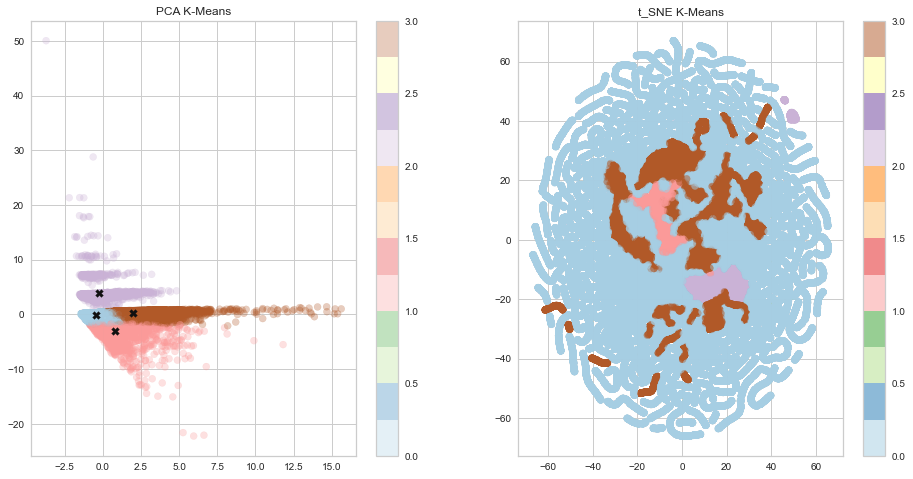

In [28]:
#Visualisation des clusters projetés
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.title('PCA K-Means')
plt.scatter(x=df_pca[:,0], y=df_pca[:,1], c=kmeans.labels_, alpha=0.3, cmap='Paired')
plt.colorbar()
plt.scatter(centroids_pca[:,0] , centroids_pca[:,1] , s=60, color='k', marker='X')

plt.subplot(1,2,2)
plt.title('t_SNE K-Means')
plt.scatter(df_tsne[:,0], df_tsne[:,1], c=kmeans.labels_, alpha=0.51, cmap='Paired')
plt.colorbar()

plt.show()

In [29]:
df = df.assign(cluster = clusters)
df.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,cluster
0,1,146.87,4.0,8.0,0
1,1,335.48,5.0,16.0,0
2,1,157.73,5.0,26.0,0
3,1,173.30,5.0,14.0,0
4,1,252.25,5.0,11.0,0


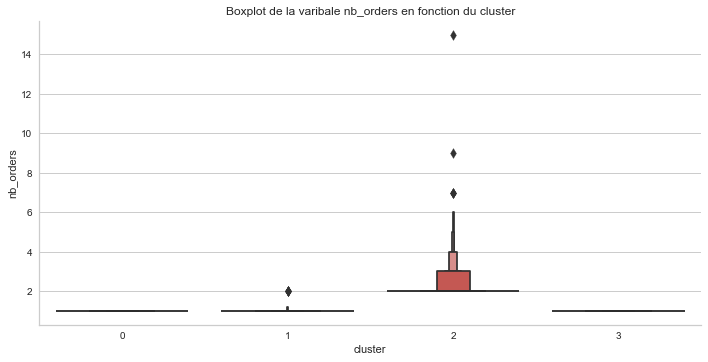

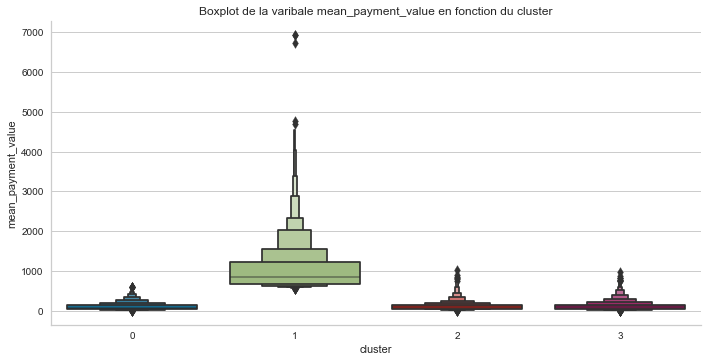

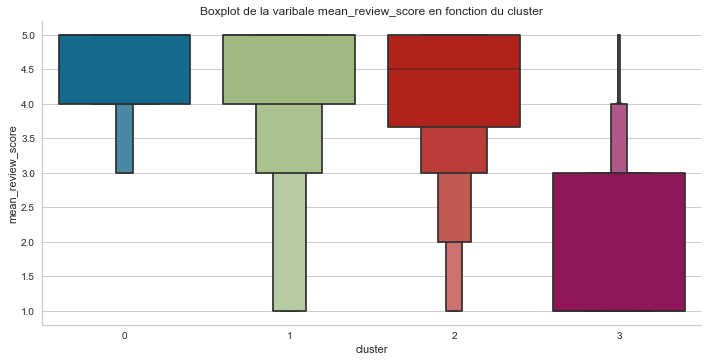

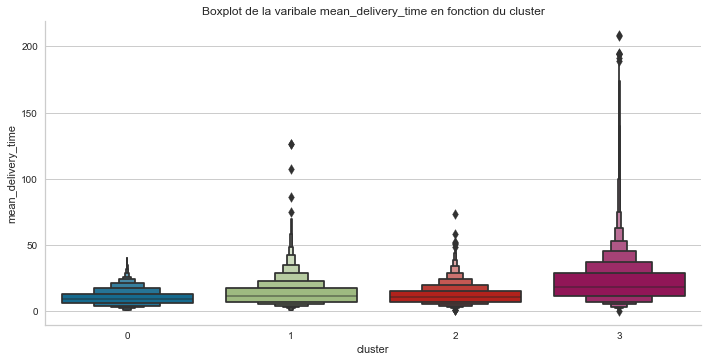

In [30]:
#Boxplot des features par cluster
for var in df.columns[:-1]:
    graph = sns.catplot(x='cluster', y=var, kind='boxen', data=df, height=5, aspect=2)
    graph.set(title = 'Boxplot de la varibale '+str(var)+' en fonction du cluster')

Le cluster 2 semble représenter les clients fidèles, ceux qui commandent souvent. Le cluster 1 les clients dépensiers. Le cluster 3 les clients généralement insatisfaits. Le cluster 0, qui représente 77% des clients, ne semble pas avoir de distinction particulière nette.

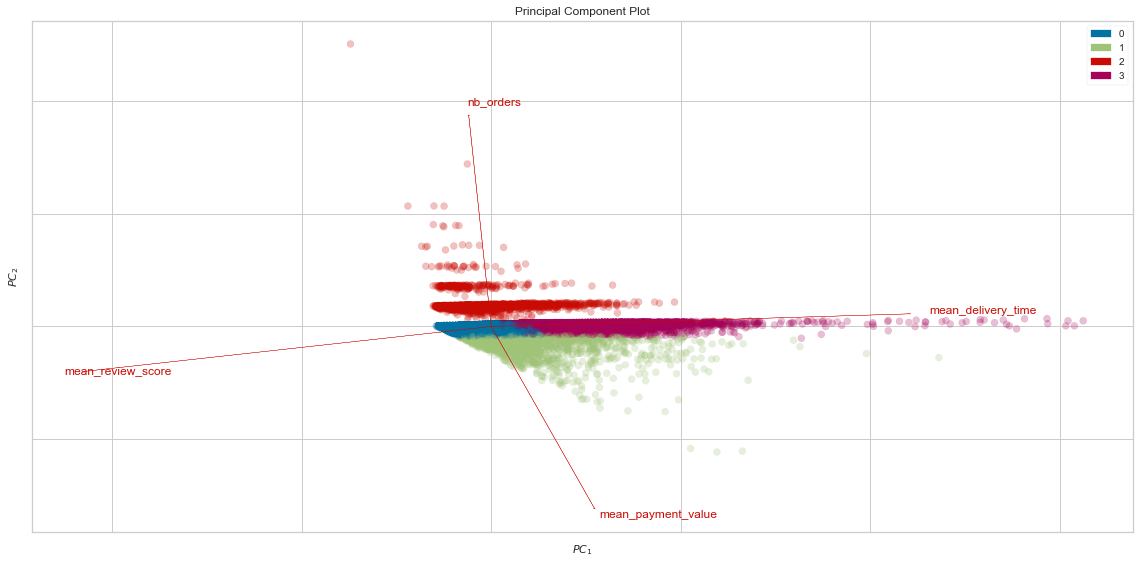

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [31]:
import yellowbrick.features

plt.figure(figsize=(16, 8))

visualizer = yellowbrick.features.PCA(projection=2, proj_features=True, features = df.columns[:-1], alpha=0.25)
visualizer.fit_transform(df_std, kmeans.labels_)
visualizer.show()

In [32]:
#Moyenne des features par cluster
df_cluster = pd.DataFrame(columns=df_std.columns)

for i in range(0,4):
    affic = df_std[(kmeans.labels_==i)]
    for column in df_cluster:
        df_cluster.loc[i,column] = affic[column].mean()
    print('cluster', i, 'contenant', affic.shape[0], 'individus')
    print(affic.mean())

cluster 0 contenant 72609 individus
0   -0.159829
1   -0.133592
2    0.392240
3   -0.209848
dtype: float64
cluster 1 contenant 2459 individus
0   -0.150105
1    4.542798
2    0.097055
3    0.136664
dtype: float64
cluster 2 contenant 2796 individus
0    5.168297
1   -0.116232
2    0.043774
3   -0.023707
dtype: float64
cluster 3 contenant 15494 individus
0   -0.159829
1   -0.073950
2   -1.861444
3    0.965991
dtype: float64


<Figure size 720x432 with 0 Axes>

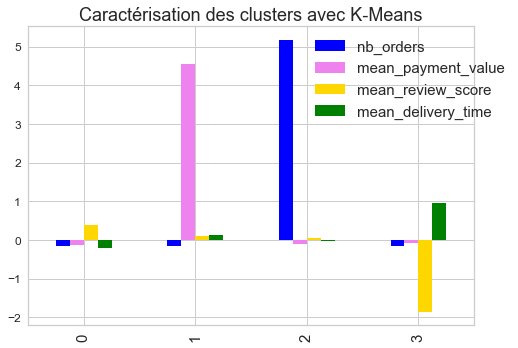

In [33]:
#Caractérisation des clusters
df_cluster.columns = ['nb_orders', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time']
plt.figure(figsize=(10,6))
ax = df_cluster.plot.bar(color=['blue', 'violet', 'gold', 'green']);
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=15)
plt.rcParams["figure.figsize"] = (13, 6);
plt.title("Caractérisation des clusters avec K-Means",fontsize=18);
plt.xticks(fontsize=15);
plt.yticks(fontsize=12);

On retrouve les catégories clients évoquée plus haut. Les catégories 1, 2 et 3 sont assez pertinentes pour le métier, d'autant plus qu'on voit ici en plus que le mécontentement des clients du cluster 3 peut être lié à des délais de livraison plus longs que la moyenne. Cependant, le cluster 0, contient la plus grande majorité des clients n'apporte pas beaucoup d'information supplémentaire. Il pourrait être intéressante de le subdiviser en sous-groupes.

### 3.1.2: K-Means avec 6 clusters

In [34]:
listeModeles.append('K-Means 6 clusters')

In [35]:
#Entraînement du modèle
start_time = timeit.default_timer()
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=0)
clusters = kmeans.fit_predict(df_std)
time = timeit.default_timer() - start_time

#Scores du modèle
listeSilhouetteScore.append(silhouette_score(X=df_std, labels=kmeans.labels_))
listeDaviesBouldin.append(davies_bouldin_score(X=df_std, labels=kmeans.labels_))
listeTempsCalcul.append(time)

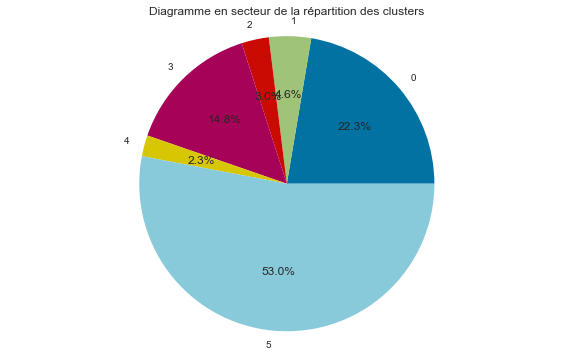

In [36]:
#Proportions des clusters
counts_kmeans = []
for i in np.unique(clusters):
    counts_kmeans.append(sum(clusters == i)/len(clusters))
labels_kmeans = np.unique(clusters)

plt.figure(figsize=(10, 6))
plt.pie(counts_kmeans, labels=labels_kmeans, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Diagramme en secteur de la répartition des clusters')
plt.show()

Malgré un cluster encore bien rempli, on obtient une répartition des clients plus intéressantes que ci-dessus.

In [37]:
#On récupère les centroïdes de nos clusters
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

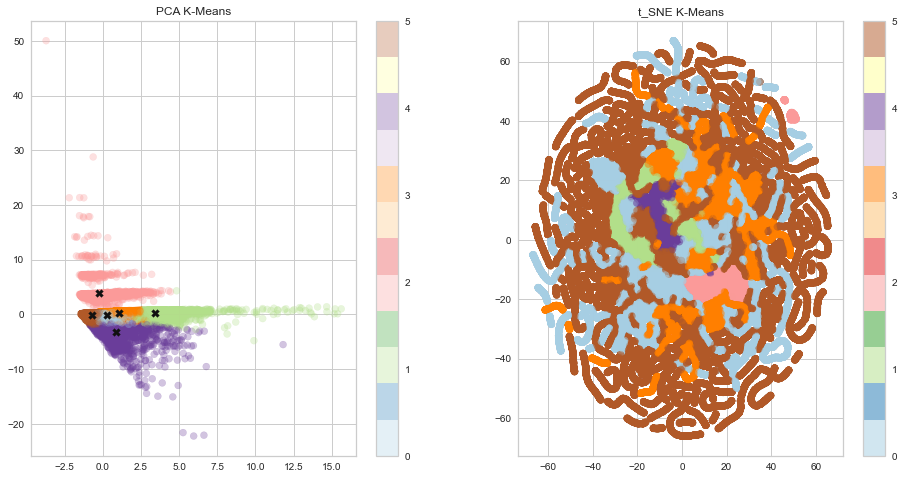

In [38]:
#Visualisation des clusters projetés
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.title('PCA K-Means')
plt.scatter(x=df_pca[:,0], y=df_pca[:,1], c=kmeans.labels_, alpha=0.3, cmap='Paired')
plt.colorbar()
plt.scatter(centroids_pca[:,0] , centroids_pca[:,1] , s=60, color='k', marker='X')

plt.subplot(1,2,2)
plt.title('t_SNE K-Means')
plt.scatter(df_tsne[:,0], df_tsne[:,1], c=kmeans.labels_, alpha=0.51, cmap='Paired')
plt.colorbar()

plt.show()

In [39]:
df = df.assign(cluster = clusters)
df.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,cluster
0,1,146.87,4.0,8.0,5
1,1,335.48,5.0,16.0,0
2,1,157.73,5.0,26.0,0
3,1,173.30,5.0,14.0,0
4,1,252.25,5.0,11.0,5


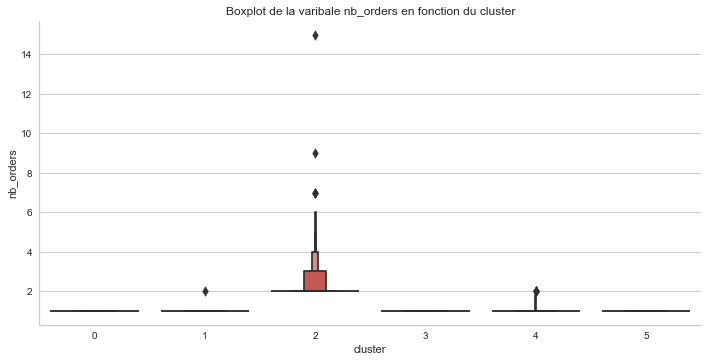

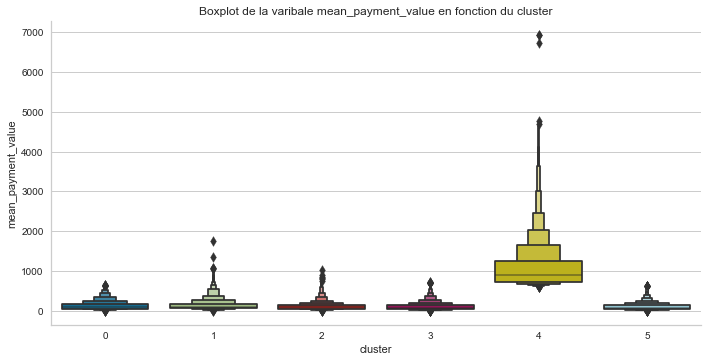

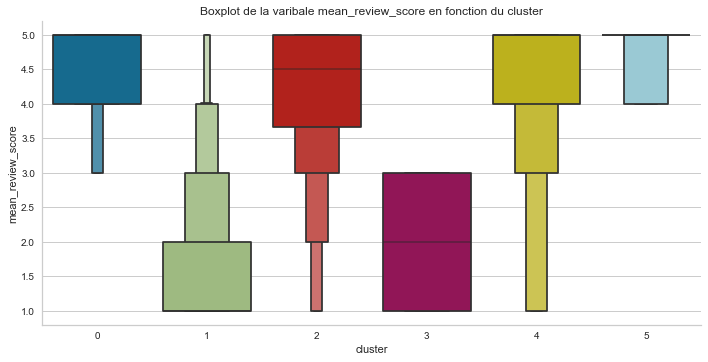

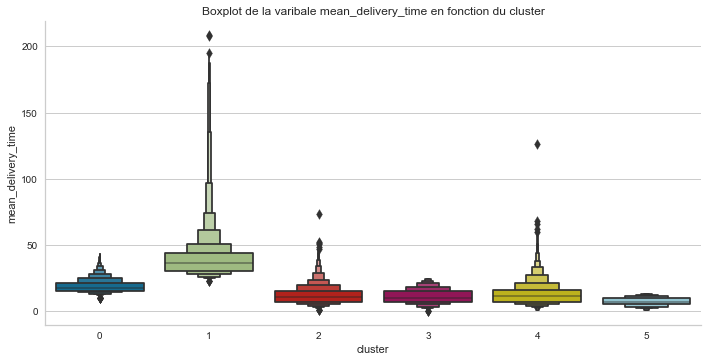

In [40]:
#Boxplot des features par cluster
for var in df.columns[:-1]:
    graph = sns.catplot(x='cluster', y=var, kind='boxen', data=df, height=5, aspect=2)
    graph.set(title = 'Boxplot de la varibale '+str(var)+' en fonction du cluster')

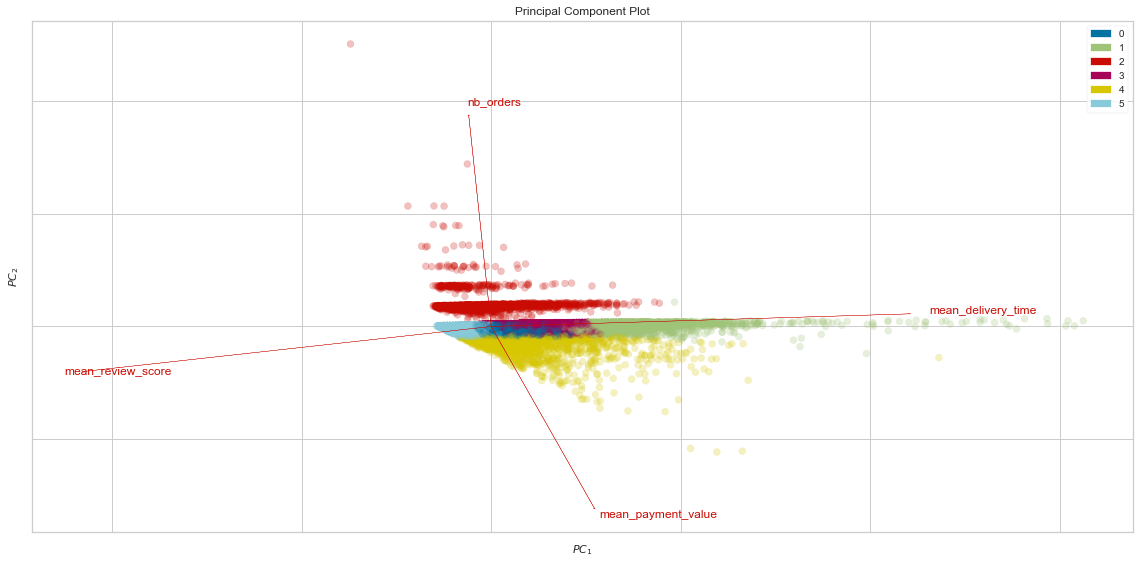

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [41]:
import yellowbrick.features

plt.figure(figsize=(16, 8))

visualizer = yellowbrick.features.PCA(projection=2, proj_features=True, features = df.columns[:-1], alpha=0.25)
visualizer.fit_transform(df_std, kmeans.labels_)
visualizer.show()

In [42]:
#Moyenne des features par cluster
df_cluster = pd.DataFrame(columns=df_std.columns)

for i in range(0,6):
    affic = df_std[(kmeans.labels_==i)]
    for column in df_cluster:
        df_cluster.loc[i,column] = affic[column].mean()
    print('cluster', i, 'contenant', affic.shape[0], 'individus')
    print(affic.mean())

cluster 0 contenant 20864 individus
0   -0.159829
1   -0.006630
2    0.339324
3    0.693591
dtype: float64
cluster 1 contenant 4298 individus
0   -0.158717
1    0.049846
2   -2.023531
3    2.898927
dtype: float64
cluster 2 contenant 2795 individus
0    5.168492
1   -0.116131
2    0.044673
3   -0.025434
dtype: float64
cluster 3 contenant 13778 individus
0   -0.159829
1   -0.145824
2   -1.669372
3   -0.117344
dtype: float64
cluster 4 contenant 2151 individus
0   -0.148713
1    4.842352
2    0.086549
3    0.081597
dtype: float64
cluster 5 contenant 49472 individus
0   -0.159829
1   -0.164903
2    0.491329
3   -0.513792
dtype: float64


<Figure size 720x432 with 0 Axes>

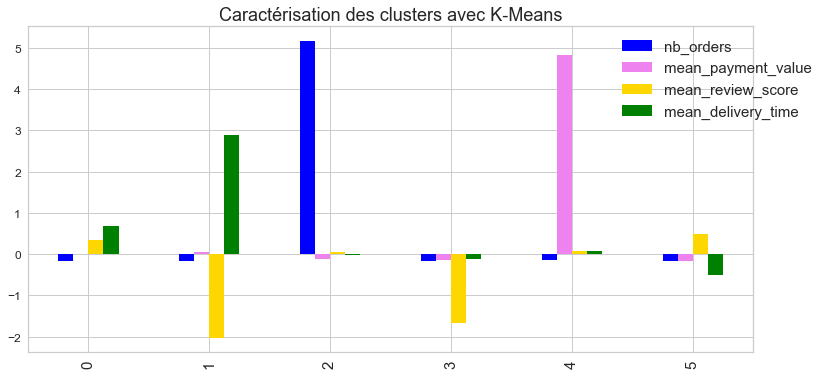

In [43]:
#Caractérisation des clusters
df_cluster.columns = ['nb_orders', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time']
plt.figure(figsize=(10,6))
ax = df_cluster.plot.bar(color=['blue', 'violet', 'gold', 'green']);
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=15)
plt.rcParams["figure.figsize"] = (13, 6);
plt.title("Caractérisation des clusters avec K-Means",fontsize=18);
plt.xticks(fontsize=15);
plt.yticks(fontsize=12);

On obtient une segmentation intéressante. On retrouve les deux clusters des fidèles (cluster 2) et des dépensiers (cluster 4) comme ci-dessus. Le groupe des insatisfaits se découpe en deux de manière clair: les râleurs (cluster 3) et les mécontents car livraison trop longue (cluster 1). Les clusters 0 et 5 sont assez similaires à la différence que les clients du cluster 5 sont moins dépensiers que la moyenne. Toutefois ce sont eux qui représentent la majorité des clients et il pourrait être intéressant de les fidéliser.

### 3.1.3: K-Means avec 8 clusters

In [44]:
listeModeles.append('K-Means 8 clusters')

In [45]:
#Entraînement du modèle
start_time = timeit.default_timer()
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=10, random_state=0)
clusters = kmeans.fit_predict(df_std)
time = timeit.default_timer() - start_time

#Scores du modèle
listeSilhouetteScore.append(silhouette_score(X=df_std, labels=kmeans.labels_))
listeDaviesBouldin.append(davies_bouldin_score(X=df_std, labels=kmeans.labels_))
listeTempsCalcul.append(time)

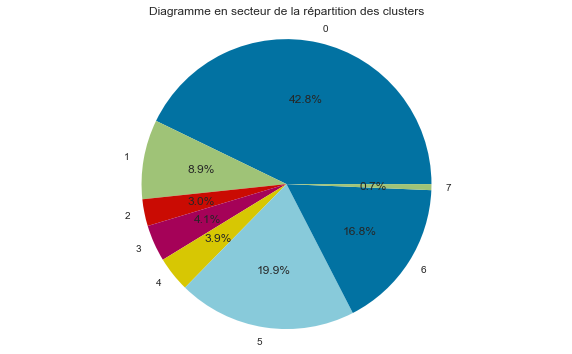

In [46]:
#Proportions des clusters
counts_kmeans = []
for i in np.unique(clusters):
    counts_kmeans.append(sum(clusters == i)/len(clusters))
labels_kmeans = np.unique(clusters)

plt.figure(figsize=(10, 6))
plt.pie(counts_kmeans, labels=labels_kmeans, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Diagramme en secteur de la répartition des clusters')
plt.show()

Il y a un cluster trop petit, cette segmentation n'est pas pertinente.

## <a name="C7">3.2: DBSCAN</a>
L'algorithme DBSCAN est une méthode de clustering par densité qui crée des clusters de proche en proche ce qui permet de former des clusters non-convexes. Il y a deux hyperparamètres à fixer:
- eps: la taille du voisinnage d'un point
- min_samples: le nombre minimum de voisin que l'on veut dans le voisinnage

Une méthode simple pour optimiser le ε consiste à regarder pour chaque observation à quelle distance se situe son voisin le plus proche. Ensuite il suffit de fixer un ε tel qu’une part « suffisamment grande » des observations aient une distance à son plus proche voisin inférieure à ε. Par « suffisamment grande » on entend 90-95% des observations qui doivent avoir au moins un voisin dans leur ε-voisinage. 

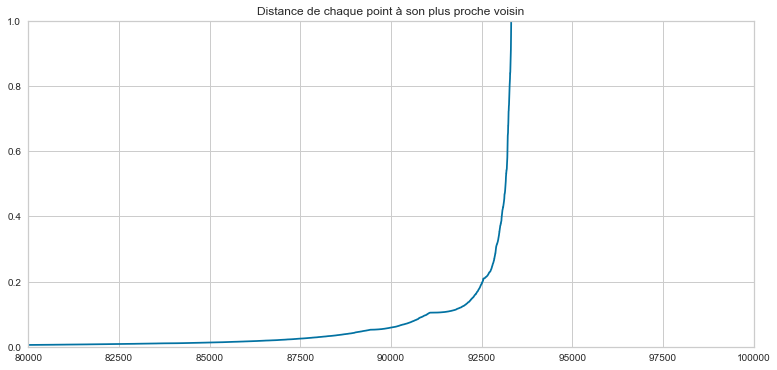

In [47]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_std)
distances, indices = nbrs.kneighbors(df_std)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.axis([80000, 100000, 0, 1])
plt.title("Distance de chaque point à son plus proche voisin")
plt.show()

Dans un premier temps, on va essayer eps = 0.3. Pour le nombre de voisins minimum, étant donné que le jeu de données est grand, on va fixer min_samples assez élévé pour ne pas risquer d'avoir des clusters trop petits.

### 3.2.1: DBSCAN première tentative

In [48]:
listeModeles.append('DBSCAN eps=0.3')

In [49]:
#Entraînement du modèle
start_time = timeit.default_timer()
dbs = DBSCAN(eps=0.3, min_samples=1000)
clusters = dbs.fit_predict(df_std)
time = timeit.default_timer() - start_time

#Scores du modèle
listeSilhouetteScore.append(silhouette_score(X=df_std, labels=dbs.labels_))
listeDaviesBouldin.append(davies_bouldin_score(X=df_std, labels=dbs.labels_))
listeTempsCalcul.append(time)

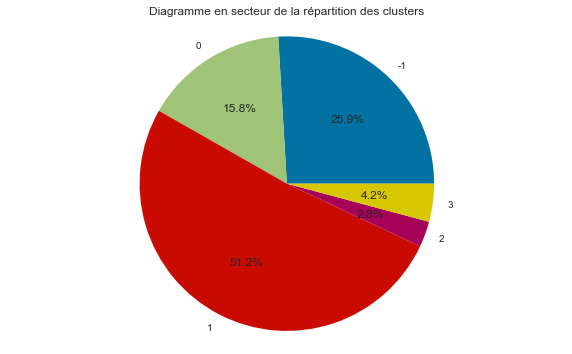

In [50]:
#Proportions des clusters
counts_dbs = []
for i in np.unique(clusters):
    counts_dbs.append(sum(clusters == i)/len(clusters))
labels_dbs = np.unique(clusters)

plt.figure(figsize=(10, 6))
plt.pie(counts_dbs, labels=labels_dbs, autopct='%1.1f%%', normalize=True)
plt.axis('equal')
plt.title('Diagramme en secteur de la répartition des clusters')
plt.show()

On obtient 5 clusters de tailles assez intéressantes

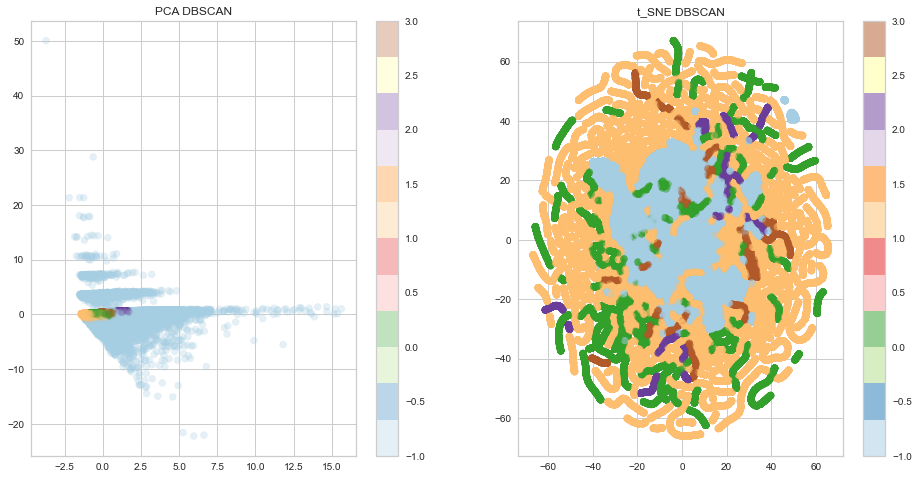

In [51]:
#Visualisation des clusters projetés
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.title('PCA DBSCAN')
plt.scatter(x=df_pca[:,0], y=df_pca[:,1], c=dbs.labels_, alpha=0.3, cmap='Paired')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('t_SNE DBSCAN')
plt.scatter(x=df_tsne[:,0], y=df_tsne[:,1], c=dbs.labels_, alpha=0.51, cmap='Paired')
plt.colorbar()

plt.show()

In [52]:
df = df.assign(cluster = clusters)
df.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,cluster
0,1,146.87,4.0,8.0,0
1,1,335.48,5.0,16.0,-1
2,1,157.73,5.0,26.0,-1
3,1,173.30,5.0,14.0,1
4,1,252.25,5.0,11.0,1


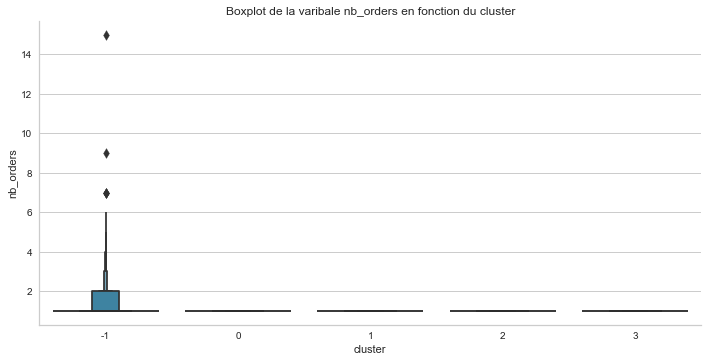

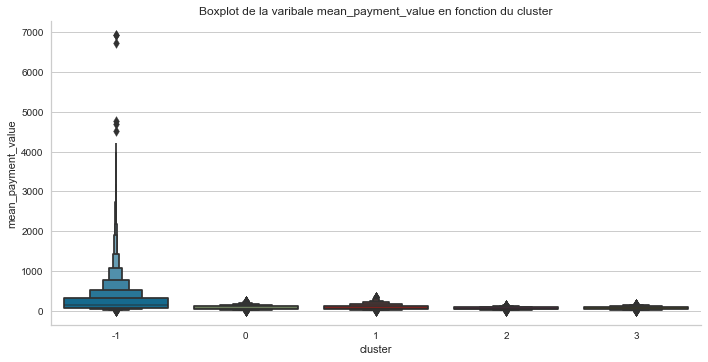

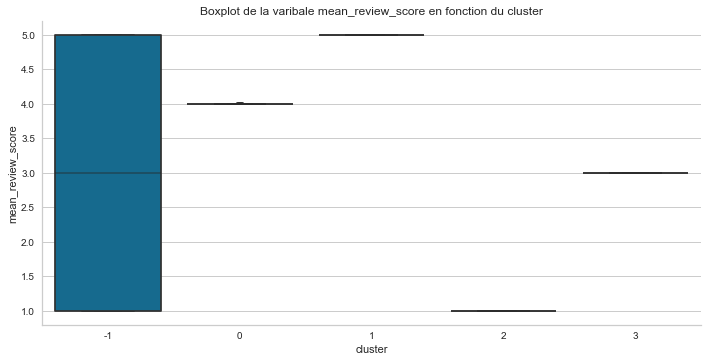

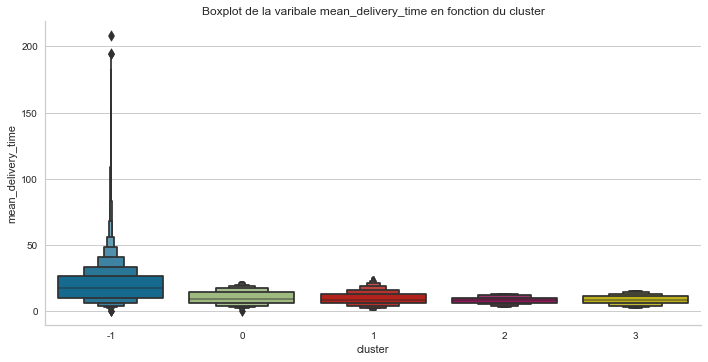

In [53]:
#Boxplot des features par cluster
for var in df.columns[:-1]:
    graph = sns.catplot(x='cluster', y=var, kind='boxen', data=df, height=5, aspect=2)
    graph.set(title = 'Boxplot de la varibale '+str(var)+' en fonction du cluster')

A première vue que les clusters 0 à 3 semblent très similaires.

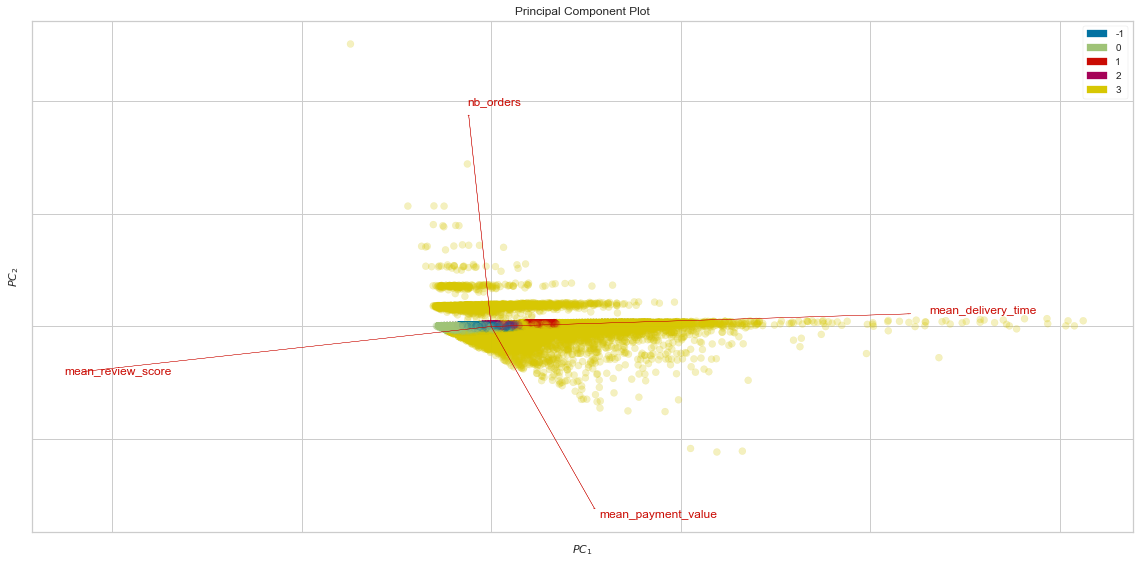

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [54]:
import yellowbrick.features

plt.figure(figsize=(16, 8))

visualizer = yellowbrick.features.PCA(projection=2, proj_features=True, features = df.columns[:-1], alpha=0.25)
visualizer.fit_transform(df_std, dbs.labels_)
visualizer.show()

In [55]:
#Moyenne des features par cluster
df_cluster = pd.DataFrame(columns=df_std.columns)

for i in range(-1,4):
    affic = df_std[(dbs.labels_==i)]
    for column in df_cluster:
        df_cluster.loc[i,column] = affic[column].mean()
    print('cluster', i, 'contenant', affic.shape[0], 'individus')
    print(affic.mean())

cluster -1 contenant 24212 individus
0    0.456450
1    0.654681
2   -0.824207
3    0.786435
dtype: float64
cluster 0 contenant 14776 individus
0   -0.159829
1   -0.256573
2   -0.119464
3   -0.216526
dtype: float64
cluster 1 contenant 47835 individus
0   -0.159829
1   -0.203491
2    0.663853
3   -0.278226
dtype: float64
cluster 2 contenant 2636 individus
0   -0.159829
1   -0.368194
2   -2.470545
3   -0.419760
dtype: float64
cluster 3 contenant 3899 individus
0   -0.159829
1   -0.347641
2   -0.903346
3   -0.365821
dtype: float64


<Figure size 720x432 with 0 Axes>

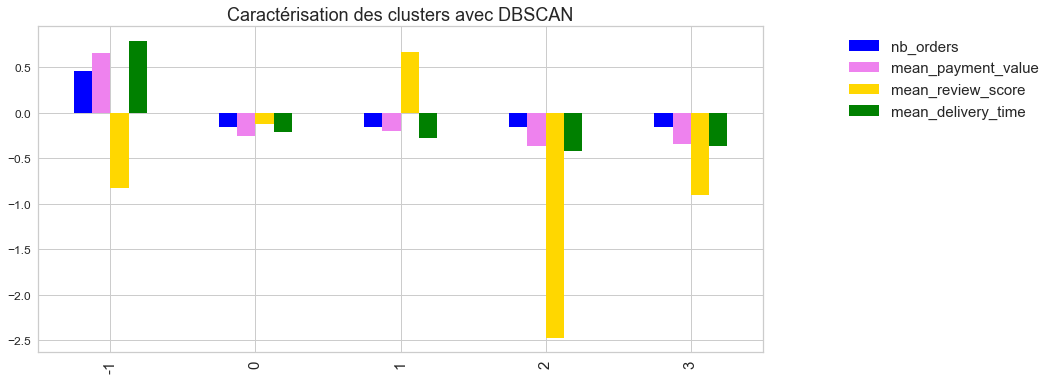

In [56]:
#Caractérisation des clusters
df_cluster.columns = ['nb_orders', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time']
plt.figure(figsize=(10,6))
ax = df_cluster.plot.bar(color=['blue', 'violet', 'gold', 'green']);
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=15)
plt.rcParams["figure.figsize"] = (13, 6);
plt.title("Caractérisation des clusters avec DBSCAN",fontsize=18);
plt.xticks(fontsize=15);
plt.yticks(fontsize=12);

Les clusters 2 et 3 sont très semblables et pourraient être regroupés en un seul. Le cluster -1 contient trop d'information et ne semble pas utilisable en pratique. On ne retrouve pas les principales catégories de clients du besoin métier. Cette segmentation n'est pas pertinente.

### 3.2.2: DBSCAN seconde tentative
Essayons de changer la valeur eps.

In [57]:
listeModeles.append('DBSCAN eps=0.2')

In [58]:
#Entraînement du modèle
start_time = timeit.default_timer()
dbs = DBSCAN(eps=0.2, min_samples=1000)
clusters = dbs.fit_predict(df_std)
time = timeit.default_timer() - start_time

#Scores du modèle
listeSilhouetteScore.append(silhouette_score(X=df_std, labels=dbs.labels_))
listeDaviesBouldin.append(davies_bouldin_score(X=df_std, labels=dbs.labels_))
listeTempsCalcul.append(time)

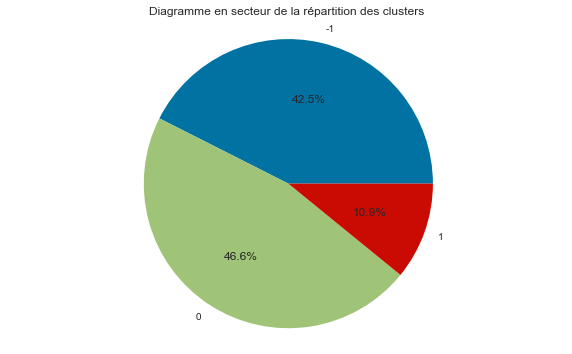

In [59]:
#Proportions des clusters
counts_dbs = []
for i in np.unique(clusters):
    counts_dbs.append(sum(clusters == i)/len(clusters))
labels_dbs = np.unique(clusters)

plt.figure(figsize=(10, 6))
plt.pie(counts_dbs, labels=labels_dbs, autopct='%1.1f%%', normalize=True)
plt.axis('equal')
plt.title('Diagramme en secteur de la répartition des clusters')
plt.show()

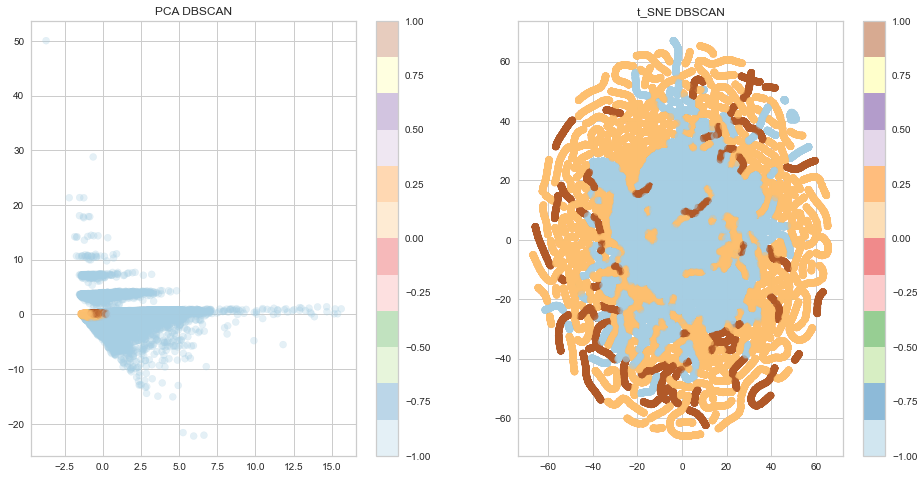

In [60]:
#Visualisation des clusters projetés
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.title('PCA DBSCAN')
plt.scatter(x=df_pca[:,0], y=df_pca[:,1], c=dbs.labels_, alpha=0.3, cmap='Paired')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('t_SNE DBSCAN')
plt.scatter(x=df_tsne[:,0], y=df_tsne[:,1], c=dbs.labels_, alpha=0.51, cmap='Paired')
plt.colorbar()

plt.show()

In [61]:
df = df.assign(cluster = clusters)
df.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,cluster
0,1,146.87,4.0,8.0,1
1,1,335.48,5.0,16.0,-1
2,1,157.73,5.0,26.0,-1
3,1,173.30,5.0,14.0,0
4,1,252.25,5.0,11.0,-1


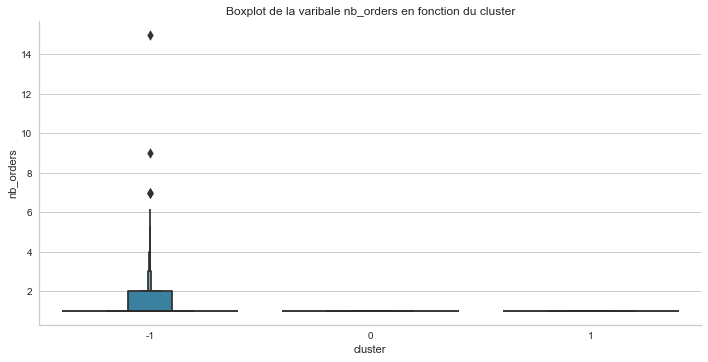

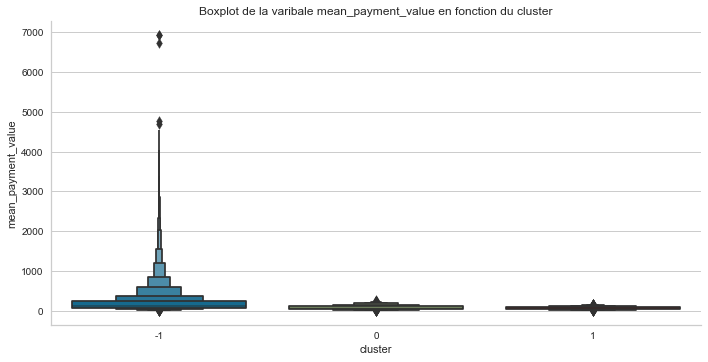

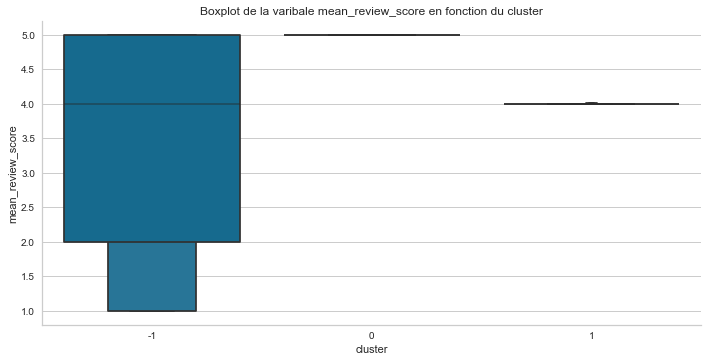

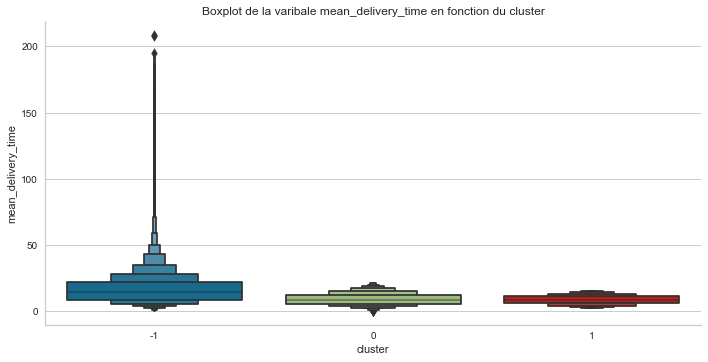

In [62]:
#Boxplot des features par cluster
for var in df.columns[:-1]:
    graph = sns.catplot(x='cluster', y=var, kind='boxen', data=df, height=5, aspect=2)
    graph.set(title = 'Boxplot de la varibale '+str(var)+' en fonction du cluster')

On retrouve les mêmes caractéristiques que précédemment, à savoir deux clusters très similaires et un troisième contenant beaucoup d'information spécifique.

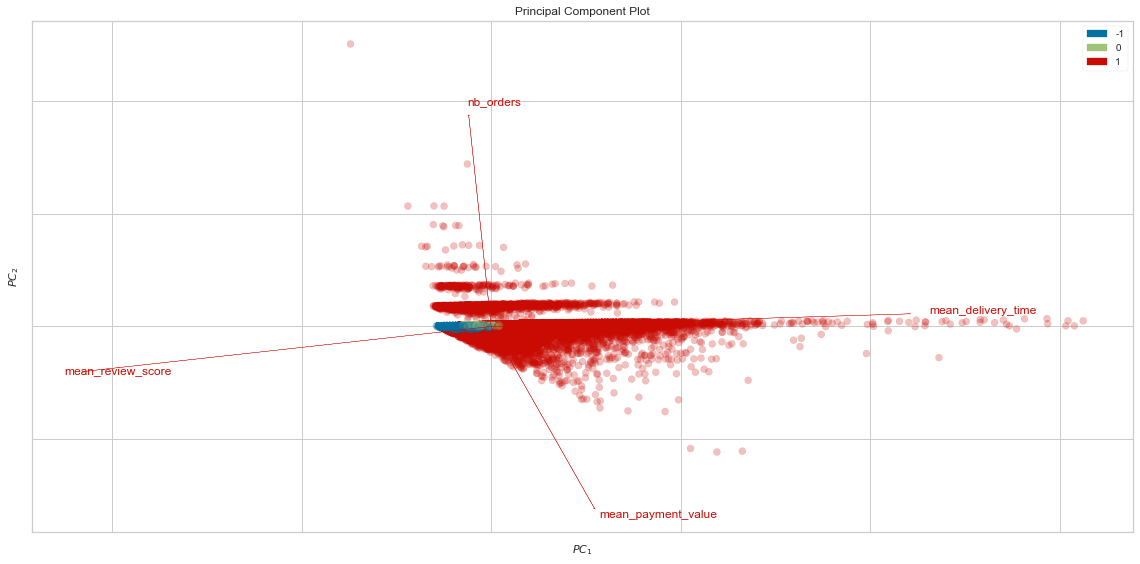

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [63]:
import yellowbrick.features

plt.figure(figsize=(16, 8))

visualizer = yellowbrick.features.PCA(projection=2, proj_features=True, features = df.columns[:-1], alpha=0.25)
visualizer.fit_transform(df_std, dbs.labels_)
visualizer.show()

In [64]:
#Moyenne des features par cluster
df_cluster = pd.DataFrame(columns=df_std.columns)

for i in range(-1,2):
    affic = df_std[(dbs.labels_==i)]
    for column in df_cluster:
        df_cluster.loc[i,column] = affic[column].mean()
    print('cluster', i, 'contenant', affic.shape[0], 'individus')
    print(affic.mean())

cluster -1 contenant 39720 individus
0    0.215834
1    0.367981
2   -0.696124
3    0.470706
dtype: float64
cluster 0 contenant 43479 individus
0   -0.159829
1   -0.255124
2    0.663853
3   -0.338858
dtype: float64
cluster 1 contenant 10159 individus
0   -0.159829
1   -0.346849
2   -0.119464
3   -0.390119
dtype: float64


<Figure size 720x432 with 0 Axes>

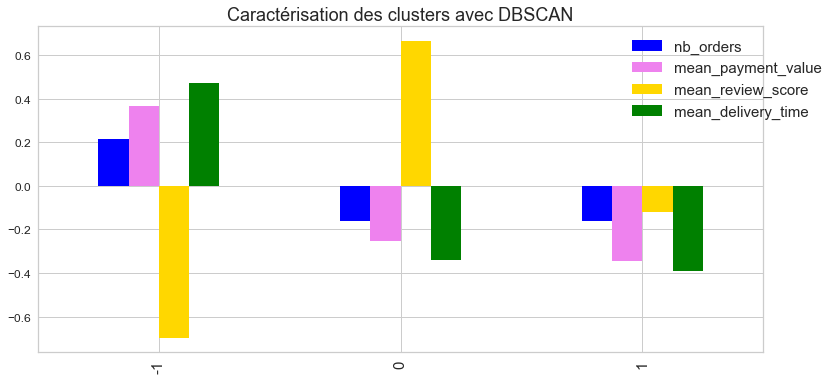

In [65]:
#Caractérisation des clusters
df_cluster.columns = ['nb_orders', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time']
plt.figure(figsize=(10,6))
ax = df_cluster.plot.bar(color=['blue', 'violet', 'gold', 'green']);
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=15)
plt.rcParams["figure.figsize"] = (13, 6);
plt.title("Caractérisation des clusters avec DBSCAN",fontsize=18);
plt.xticks(fontsize=15);
plt.yticks(fontsize=12);

Les clusters sont trop larges et difficilement exploitables pour le métier. On ne retiendra pas cette segmentation non pertinente.

## <a name="C8">3.3: Agglomerative Clustering</a>
Une autre méthode possible est le clustering hiérarchique. On teste tous les nombres de clusters possibles. Cependant, comme la complexité peut vite devenir très importante sur un grand jeu de données, on peut fixer à l'avance un nombre de clusters à trouver. Aux vues du problème métier et des résultats obtenus ci-dessus, essayons dans un premier temps de trouver 6 clusters.
### 3.3.1: Agglomerative Clustering avec 6 clusters

In [66]:
listeModeles.append('Agglomerative Clustering 6 clusters')

In [67]:
#Le jeu de données étant grand, on sélectionne aléatoirement 25% du jeu de données
sample = round(df.shape[0]*0.25)
df_sample = df_std.sample(sample, random_state=2).copy()
df_sample.shape

(23340, 4)

In [68]:
#On récupère le jeu réduit original
df_reduit = df.iloc[df_sample.index, :]

In [69]:
#Entraînement du modèle
start_time = timeit.default_timer()
aggClus = AgglomerativeClustering(n_clusters=6)
clusters = aggClus.fit_predict(df_sample)
time = timeit.default_timer() - start_time

#Scores du modèle
listeSilhouetteScore.append(silhouette_score(X=df_sample, labels=aggClus.labels_))
listeDaviesBouldin.append(davies_bouldin_score(X=df_sample, labels=aggClus.labels_))
listeTempsCalcul.append(time)

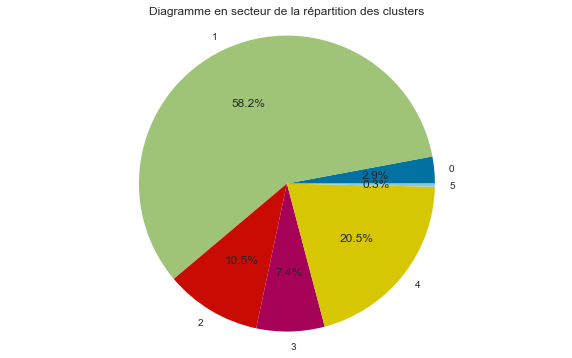

In [70]:
#Proportions des clusters
counts_aggClus = []
for i in np.unique(clusters):
    counts_aggClus.append(sum(clusters == i)/len(clusters))
labels_aggClus = np.unique(clusters)

plt.figure(figsize=(10, 6))
plt.pie(counts_aggClus, labels=labels_aggClus, autopct='%1.1f%%', normalize=True)
plt.axis('equal')
plt.title('Diagramme en secteur de la répartition des clusters')
plt.show()

Un des clusters est beaucoup trop petit. Cette segmentation ne peut être pertinente pour le problème métier. Essayons maintenant avec 5 clusters.

### 3.3.2: Agglomerative Clustering avec 5 clusters

In [71]:
listeModeles.append('Agglomerative Clustering 5 clusters')

In [72]:
#Entraînement du modèle
start_time = timeit.default_timer()
aggClus = AgglomerativeClustering(n_clusters=5)
clusters = aggClus.fit_predict(df_sample)
time = timeit.default_timer() - start_time

#Scores du modèle
listeSilhouetteScore.append(silhouette_score(X=df_sample, labels=aggClus.labels_))
listeDaviesBouldin.append(davies_bouldin_score(X=df_sample, labels=aggClus.labels_))
listeTempsCalcul.append(time)

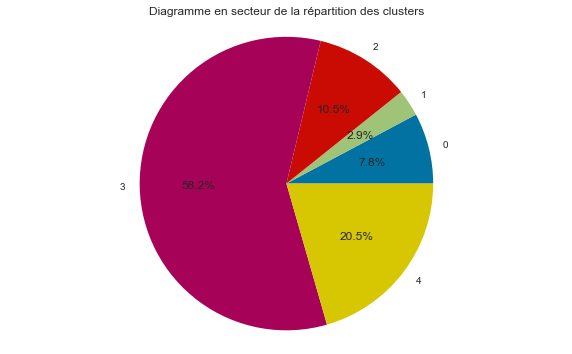

In [73]:
#Proportions des clusters
counts_aggClus = []
for i in np.unique(clusters):
    counts_aggClus.append(sum(clusters == i)/len(clusters))
labels_aggClus = np.unique(clusters)

plt.figure(figsize=(10, 6))
plt.pie(counts_aggClus, labels=labels_aggClus, autopct='%1.1f%%', normalize=True)
plt.axis('equal')
plt.title('Diagramme en secteur de la répartition des clusters')
plt.show()

In [74]:
#PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_sample)

#TSNE
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_sample)

C:\Users\vbour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\vbour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


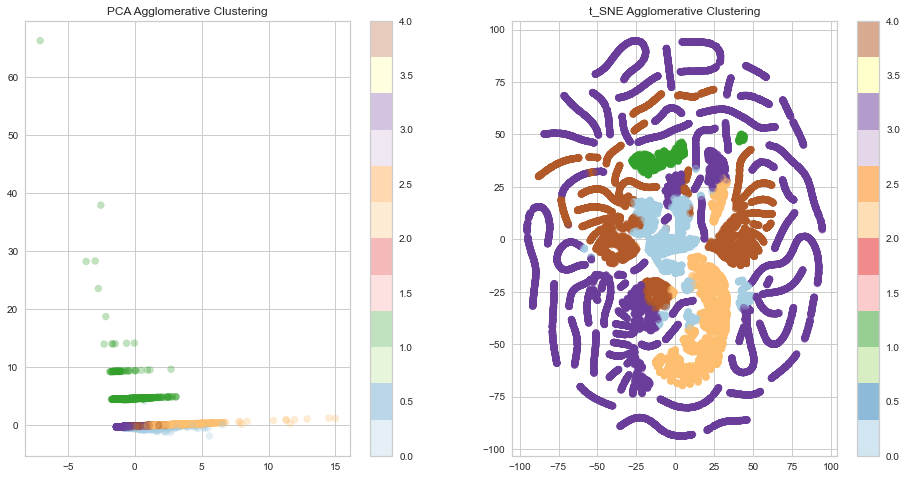

In [75]:
#Visualisation des clusters projetés
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.title('PCA Agglomerative Clustering')
plt.scatter(x=df_pca[:,0], y=df_pca[:,1], c=aggClus.labels_, alpha=0.3, cmap='Paired')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('t_SNE Agglomerative Clustering')
plt.scatter(x=df_tsne[:,0], y=df_tsne[:,1], c=aggClus.labels_, alpha=0.51, cmap='Paired')
plt.colorbar()

plt.show()

In [76]:
df_reduit = df_reduit.assign(cluster = clusters)
df_reduit.head()

,nb_orders,mean_payment_value,mean_review_score,mean_delivery_time,cluster
6315,1,121.48,5.0,5.0,3
90445,1,84.69,5.0,13.0,3
37778,1,50.09,4.0,7.0,3
19234,1,285.10,5.0,12.0,0
19845,1,123.87,4.0,11.0,3


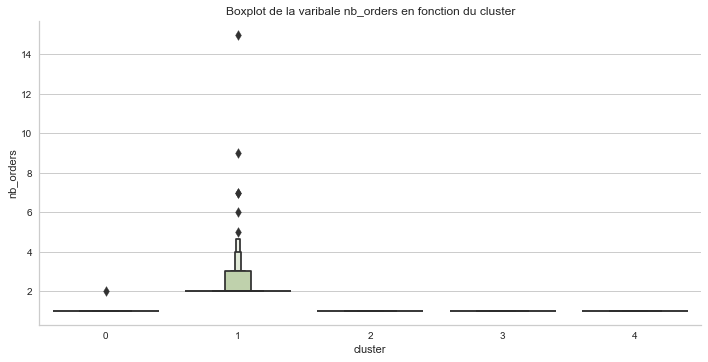

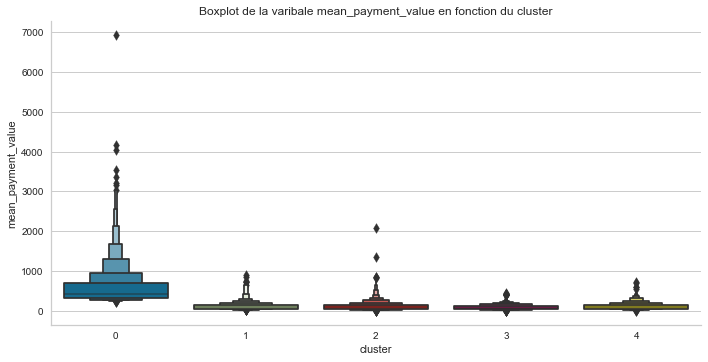

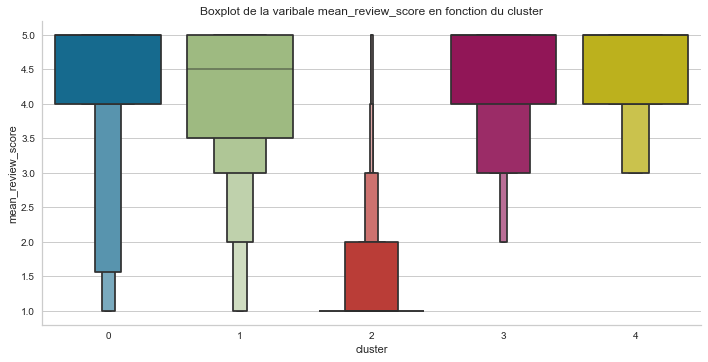

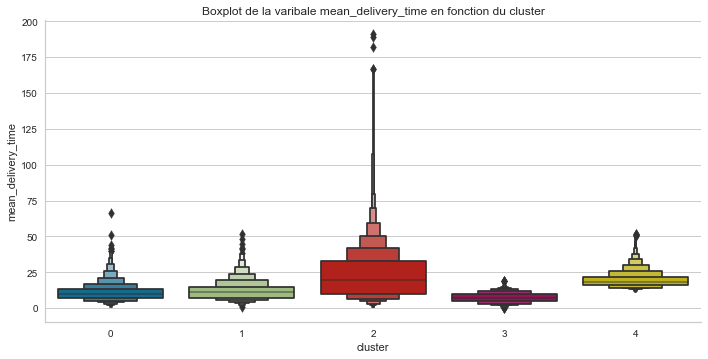

In [77]:
#Boxplot des features par cluster
for var in df_reduit.columns[:-1]:
    graph = sns.catplot(x='cluster', y=var, kind='boxen', data=df_reduit, height=5, aspect=2)
    graph.set(title = 'Boxplot de la varibale '+str(var)+' en fonction du cluster')

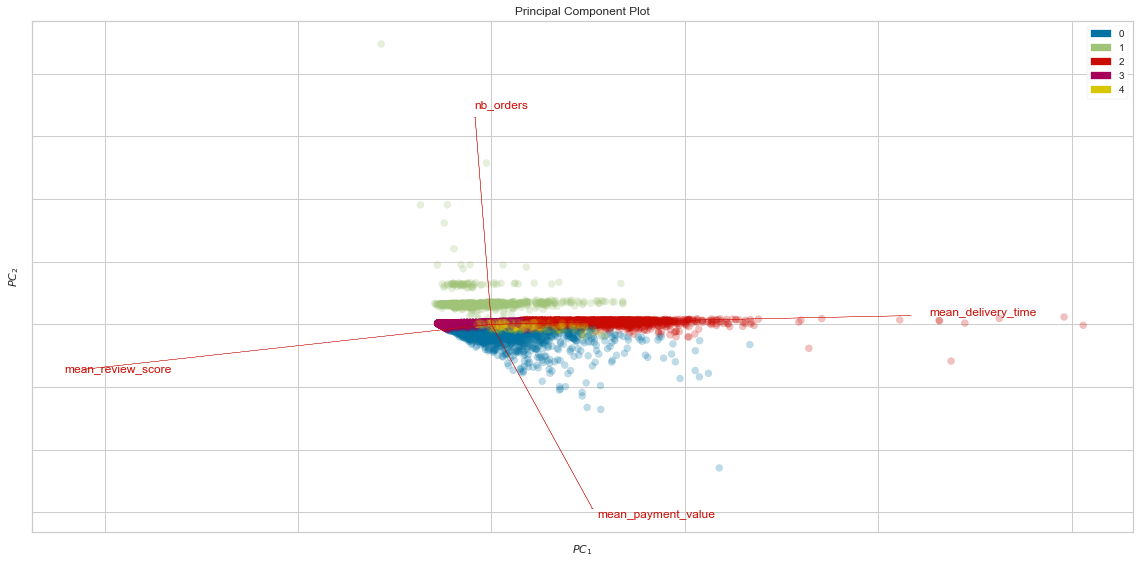

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [78]:
import yellowbrick.features

plt.figure(figsize=(16, 8))

visualizer = yellowbrick.features.PCA(projection=2, proj_features=True, features = df_reduit.columns[:-1], alpha=0.25)
visualizer.fit_transform(df_sample, aggClus.labels_)
visualizer.show()

In [79]:
#Moyenne des features par cluster
df_cluster = pd.DataFrame(columns=df_sample.columns)

for i in range(0,5):
    affic = df_sample[(aggClus.labels_==i)]
    for column in df_cluster:
        df_cluster.loc[i,column] = affic[column].mean()
    print('cluster', i, 'contenant', affic.shape[0], 'individus')
    print(affic.mean())

cluster 0 contenant 1818 individus
0   -0.157199
1    2.276727
2    0.219970
3   -0.137006
dtype: float64
cluster 1 contenant 685 individus
0    5.355737
1   -0.114046
2    0.011203
3    0.000968
dtype: float64
cluster 2 contenant 2456 individus
0   -0.159829
1   -0.119995
2   -2.315790
3    1.174672
dtype: float64
cluster 3 contenant 13586 individus
0   -0.159829
1   -0.244119
2    0.297030
3   -0.466462
dtype: float64
cluster 4 contenant 4795 individus
0   -0.159829
1   -0.108700
2    0.267389
3    0.795709
dtype: float64


<Figure size 720x432 with 0 Axes>

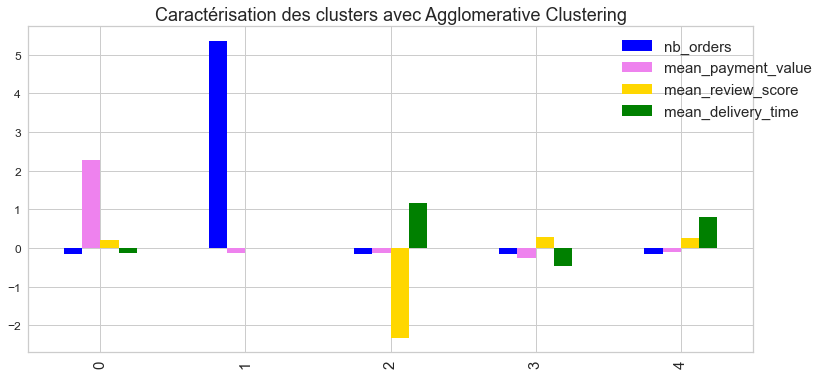

In [80]:
#Caractérisation des clusters
df_cluster.columns = ['nb_orders', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time']
plt.figure(figsize=(10,6))
ax = df_cluster.plot.bar(color=['blue', 'violet', 'gold', 'green']);
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=15)
plt.rcParams["figure.figsize"] = (13, 6);
plt.title("Caractérisation des clusters avec Agglomerative Clustering",fontsize=18);
plt.xticks(fontsize=15);
plt.yticks(fontsize=12);

On retrouve les mêmes clusters que pour le K-Means avec 6 clsuters, à l'exception du groupe des râleurs. 

# <a name="C9">Partie 4: Sélection du modèle</a>

In [81]:
#On rassemble tous les scores dans un tableau pour la comparaison 
tab = np.array([listeSilhouetteScore, listeDaviesBouldin, listeTempsCalcul])
dataComparaison = pd.DataFrame(tab, index=['Score de Silhouette', 'Score Davies Bouldin', 'Temps de Calcul'], 
                               columns=listeModeles)
dataComparaison

,K-Means 4 clusters,K-Means 6 clusters,K-Means 8 clusters,DBSCAN eps=0.3,DBSCAN eps=0.2,Agglomerative Clustering 6 clusters,Agglomerative Clustering 5 clusters
Score de Silhouette,0.547565,0.386366,0.390223,0.162327,0.090754,0.342169,0.333536
Score Davies Bouldin,0.804298,0.852013,0.820280,1.665363,1.775293,0.888254,0.974400
Temps de Calcul,0.939960,1.363340,1.889955,29.487150,15.057859,35.943649,39.912353


On écarte tout d'abord les modèles DBSCAN qui ont des scores faibles et des temps de calcul élevés.</br>
On va également écarter les modèles Agglomerative Clustering qui ont un coût de calcul bien trop important compte tenu du fait que l'entraînement du modèle a été fait en utilisant seulement 1/4 du jeu de données total.</br>
Il nous reste donc à choisir parmi les k-means. On se souvient qu'avec 8 clusters on obtenait un cluster contenant moins de 1% des clients et que cela ne semblait pas pertinent pour le problème métier. Enfin, même si on obtient de meilleurs scores avec 4 clusters, c'est avec 6 clusters que l'on obtenait la segmentation la plus pertinente.

| `Clusters` | `Description` | `Nom` | `Proportion` |
| ---------- | ------------- | ----- | ------------ |
| **Cluster 0** | - Très contents</br> - Dépenses dans la moyenne</br>- Délais de livraison plus longs que la moyenne  | **Prometteurs** | 22% |
| **Cluster 1** | - Pas contents</br> - Dépenses dans la moyenne</br>- Délais de livraison très longs | **Mécontents** | 5% |
| **Cluster 2** | - Contents</br> - Beaucoup de commandes<br> - Dépenses plus faibles que la moyenne</br> - Délais de livraison dans la moyenne | **Fidèles** | 3% |
| **Cluster 3** | - Pas contents</br> - Dépenses plus faibles que la moyenne</br> - Délais de livraison courts  | **Râleurs** | 15% |
| **Cluster 4** | - Contents<br> - Dépenses très élevées</br> - Délais de livraison dans la moyenne | **Dépensiers** | 2% |
| **Cluster 5** | - Très contents</br> - Dépenses plus faibles que la moyenne</br> - Délais de livraison très rapides | **Lambdas** | 53% |

# <a name="C10">Partie 5: Exportation du jeu de données</a>

In [82]:
#On récupère d'abord les clusters
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=0)
clusters = kmeans.fit_predict(df_std)
data = data.assign(cluster = clusters)
data.head()

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng,RFM_R,RFM_F,RFM_M,RFM,cluster
0,1,2.0,1.0,146.87,4.0,8.0,2017-05-16 15:05:35,office_furniture,-20.509898,-47.397866,1.0,1.0,4.0,114.0,5
1,1,8.0,3.0,335.48,5.0,16.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746,3.0,1.0,5.0,315.0,0
2,1,7.0,1.0,157.73,5.0,26.0,2018-05-19 16:07:45,office_furniture,-23.527788,-46.660310,4.0,1.0,4.0,414.0,0
3,1,1.0,1.0,173.30,5.0,14.0,2018-03-13 16:06:38,office_furniture,-23.496930,-46.185352,4.0,1.0,4.0,414.0,0
4,1,8.0,1.0,252.25,5.0,11.0,2018-07-29 09:51:30,home_confort,-22.987222,-47.151073,5.0,1.0,5.0,515.0,5


In [83]:
data.to_csv('dataCluster.csv', sep = ',', encoding='utf_8', index=False)